In [7]:
#先使用加州数据集进行随机森林回归的拟合与优化
from sklearn.datasets import fetch_california_housing
import numpy as np
housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]


In [8]:
#分割测试集与数据集，测试集占20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
#不设置超参数，进行随机森林回归的拟合
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)


0.9735568181641604

In [10]:
from sklearn.model_selection import cross_val_score
score_pre = cross_val_score(rfr, X_train, y_train, cv = 10).mean()
score_pre

0.8079698709886431

In [69]:
# 设置参数优化范围
import numpy as np
#在50到3000中均匀取60个数
n_estimators_range=[int(x) for x in np.linspace(start=50,stop=3000,num=60)]
#设置max_features的三种方法
max_features_range=['auto','sqrt','log2']
#从10到500中均匀取50个数
max_depth_range=[int(x) for x in np.linspace(10,500,num=50)]
max_depth_range.append(None)
#分别设置2，5，10个拆分内部节点的样本数
min_samples_split_range=[2,5,10]
#分别设置1，2，4，8个拆分叶结点的样本数
min_samples_leaf_range=[1,2,4,8]

rfr_hp_range={'n_estimators':n_estimators_range,
              'max_features':max_features_range,
              'max_depth':max_depth_range,
              'min_samples_split':min_samples_split_range,
              'min_samples_leaf':min_samples_leaf_range
             }
print(rfr_hp_range)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8]}


In [70]:
from sklearn.model_selection import RandomizedSearchCV

rfr_base=RandomForestRegressor()
#使用3折交叉验证进行验证，每次迭代次数为n_iter=200，总的匹配次数为3*200=600次
rfr_random=RandomizedSearchCV(estimator=rfr_base,
                              param_distributions=rfr_hp_range,
                              n_iter=200,
                              n_jobs=-1,
                              cv=3,
                              verbose=1,
                              random_state=42)
rfr_random.fit(X_train,y_train)

best_hp_now=rfr_random.best_params_
print(best_hp_now)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'n_estimators': 1650, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 330}


In [72]:
from sklearn.model_selection import GridSearchCV
#使用网格搜索，在随机匹配择优的基础上选取临近的超参数进行遍历匹配择优
rfr_hp_range_2={'n_estimators':[1600,1650,1700],
                'max_depth':[320,330,340],
                }
rfr_2_base=RandomForestRegressor()
rfr_2_random=GridSearchCV(estimator=rfr_2_base,
                          param_grid=rfr_hp_range_2,
                          cv=3,
                          verbose=1,
                          n_jobs=-1)
rfr_2_random.fit(X_train,y_train)

best_hp_now_2=rfr_2_random.best_params_

print(best_hp_now_2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 330, 'n_estimators': 1650}


In [29]:
#使用最终优化好的超参数进行回归拟合best模型
best = RandomForestRegressor(n_estimators=1650,min_samples_split=2,min_samples_leaf=1,max_features='log2',max_depth=330)
best.fit(X_train,y_train)
best.score(X_test,y_test)

0.8167482347894894

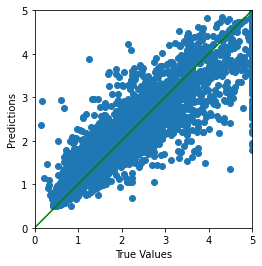

In [31]:
import matplotlib.pyplot as plt
#使用测试集数据得到预测值
y_pred = best.predict(X_test)
#绘制测试集数据与回归数据的散点图
plt.figure()
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(y_test,y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
Lims=[0,5]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims, Lims, color = 'g')
plt.show()

In [75]:
#计算优化后模型的性能指标
from sklearn import metrics
import scipy.stats as stats
random_forest_pearson_r=stats.pearsonr(y_test,y_pred)
random_forest_R2=metrics.r2_score(y_test,y_pred)
print(random_forest_R2)
random_forest_RMSE=metrics.mean_squared_error(y_test,y_pred)**0.5
print('Pearson correlation coefficient is {0}, and RMSE is {1}.'.format(random_forest_pearson_r[0],
                                                                        random_forest_RMSE))

0.8182518043452683
Pearson correlation coefficient is 0.9056775228158338, and RMSE is 0.48802097021034246.


In [1]:
#使用农田甲烷排放数据
import pandas as pd
#data processing
#导入并删除缺失数据
data=pd.read_excel("CH4-analysis1212.xlsx").dropna()
#将分类变量转换为数字
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()
data['Rotation'] = encoder.fit_transform(data['Rotation'])
print(encoder.inverse_transform([0,1,2,3,4,5,6]))
data['Irrigation'] = encoder.fit_transform(data['Irrigation'])
print(encoder.inverse_transform([0,1,2]))
data['N'] = encoder.fit_transform(data['N'])
print(encoder.inverse_transform([0,1,2,3]))
data['Tillage'] = encoder.fit_transform(data['Tillage'])
print(encoder.inverse_transform([0,1,2]))
data['Return_Type'] = encoder.fit_transform(data['Return_Type'])
print(encoder.inverse_transform([0,1,2]))

from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(data.iloc[:, 2:7], 
                                                        data.loc[:,['exp.CH4 kg hm-2']], 
                                                        test_size=0.2,
                                                        random_state=0)

['Early rice of Double Rice' 'Late rice of Double Rice' 'Rice Fallow'
 'Rice-Crayfish' 'Rice-Rapeseed' 'Rice-Wheat' 'Rice-Winter Cover']
['Continuous Flooding' 'Intermittent Irrigation' 'Midseason Draige']
['N 140-210' 'N 210-280' 'N<140' 'N>280']
['Conventiol Tillage' 'No Tillage' 'Rotary Tillage']
['Straw Buried' 'Straw Burning' 'Straw Mulching']


In [4]:
#使用随机匹配择优，此处参数设置与前面相同
n_estimators_range=[int(x) for x in np.linspace(start=50,stop=3000,num=50)]
max_features_range=['auto','sqrt','log2']
max_depth_range=[int(x) for x in np.linspace(10,500,num=50)]
max_depth_range.append(None)
min_samples_split_range=[2,5,10]
min_samples_leaf_range=[1,2,4,8]

rfr_hp_range_3={'n_estimators':n_estimators_range,
                        'max_features':max_features_range,
                        'max_depth':max_depth_range,
                        'min_samples_split':min_samples_split_range,
                        'min_samples_leaf':min_samples_leaf_range
                        }
print(rfr_hp_range_3)

{'n_estimators': [50, 110, 170, 230, 290, 351, 411, 471, 531, 591, 652, 712, 772, 832, 892, 953, 1013, 1073, 1133, 1193, 1254, 1314, 1374, 1434, 1494, 1555, 1615, 1675, 1735, 1795, 1856, 1916, 1976, 2036, 2096, 2157, 2217, 2277, 2337, 2397, 2458, 2518, 2578, 2638, 2698, 2759, 2819, 2879, 2939, 3000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8]}


In [11]:
from sklearn.model_selection import RandomizedSearchCV
rfr_3_base=RandomForestRegressor()
rfr_3_random=RandomizedSearchCV(estimator=rfr_3_base,
                                param_distributions=rfr_hp_range_3,
                                n_iter=200,
                                n_jobs=-1,
                                cv=3,
                                verbose=1,
                                random_state=0
                                )
rfr_3_random.fit(X1_train, Y1_train)

best_hp_now_3=rfr_3_random.best_params_
print(best_hp_now_3)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yokeman/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

{'n_estimators': 832, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 260}


In [13]:
from sklearn.model_selection import GridSearchCV
#使用网格搜索，在随机匹配择优的基础上选取临近的超参数进行遍历匹配择优
rfr_hp_range_4={'n_estimators':[800,832,900],
                'min_samples_split':[4,5,6],
                'max_depth':[200,260,300],
                }
rfr_4_base=RandomForestRegressor()
rfr_4_random=GridSearchCV(estimator=rfr_4_base,
                          param_grid=rfr_hp_range_4,
                          cv=3,
                          verbose=1,
                          n_jobs=-1)
rfr_4_random.fit(X_train,y_train)

best_hp_now_4=rfr_4_random.best_params_
print(best_hp_now_4)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


NameError: name 'best_hp_now_2' is not defined

In [14]:
print(best_hp_now_4)

{'max_depth': 300, 'min_samples_split': 4, 'n_estimators': 832}


In [15]:
best2 = RandomForestRegressor(n_estimators=832,min_samples_split=4,min_samples_leaf=1,max_features='sqrt',max_depth=300)
best2.fit(X1_train,Y1_train)
best2.score(X1_test,Y1_test)

/var/folders/r5/q9w2xsxx177c_bbcv0ntcfh40000gn/T/ipykernel_95137/2309166314.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best2.fit(X1_train,Y1_train)


0.36768026385305697

In [27]:
Y1_pred = best2.predict(X1_test)

from sklearn import metrics
import scipy.stats as stats
random_forest_pearson_r=stats.pearsonr(Y1_test.iloc[:,0].values,Y1_pred)
random_forest_R2=metrics.r2_score(Y1_test.iloc[:,0].values,Y1_pred)
print(random_forest_R2)
random_forest_RMSE=metrics.mean_squared_error(Y1_test.iloc[:,0].values,Y1_pred)**0.5
print('Pearson correlation coefficient is {0}, and RMSE is {1}.'.format(random_forest_pearson_r[0],
                                                                        random_forest_RMSE))

0.36768026385305697
Pearson correlation coefficient is 0.6138946306822202, and RMSE is 141.9212879497431.


In [18]:
Y1_pred

array([175.87410325, 274.18275534, 447.28734944, 175.87410325,
       462.50232747, 437.76469223, 290.84635766, 236.28624175,
       408.13666204, 262.81486839, 458.75001444, 408.13666204,
       437.76469223, 296.83345788, 307.16431981, 244.5784842 ,
       185.28764881, 243.38352283, 282.38168854, 282.38168854,
       255.070144  , 185.28764881, 244.5784842 , 275.24067187,
       255.070144  , 447.28734944, 200.94486915, 175.87410325,
       175.87410325])

In [26]:
Y1_test.iloc[:,0].values

array([ 81.7       , 288.3       , 400.        ,  81.7       ,
       521.        , 494.        , 306.7       , 300.5       ,
       486.3       , 486.6       , 525.41333333, 409.9       ,
       376.        , 272.        , 229.33333333, 910.        ,
       168.24      , 224.2       , 241.7       , 312.3       ,
       208.1       , 121.34666667, 131.8       , 273.8       ,
       150.        , 448.        , 178.5       , 127.1713    ,
       121.8       ])

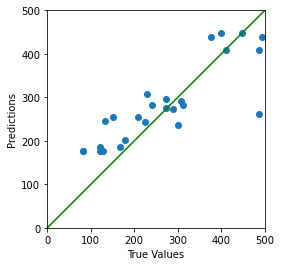

In [36]:
import matplotlib.pyplot as plt
#使用测试集数据得到预测值
Y1_pred = best2.predict(X1_test)
#绘制测试集数据与回归数据的散点图
plt.figure()
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(Y1_test,Y1_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
Lims=[0,500]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims, Lims, color = 'g')
plt.show()